In [3]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
import os
import glob
import ternary
import helpers.fileload as fl
#from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.plotting import quat_slice_scatter, add_colorbar, scatter_slices
from helpers.quaternary_plt import QuaternaryAxes


import pymatgen as mg
import pypif.pif

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/eis') 
#pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/eis/plots')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

## ASR

In [5]:
data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['wet']})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['ASR'] > 0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_ASR'] = np.log10(data['ASR'])

In [6]:
from sklearn.decomposition import PCA, KernelPCA

In [159]:
comp_dims = ['Co','Fe','Zr','Y']
comp_data = data[comp_dims]

reconstructed = data.copy()
kreconstructed = data.copy()

pca = PCA(n_components=2)
kpca = KernelPCA(kernel='poly',n_components=2,fit_inverse_transform=True,gamma=10)

trans = pd.DataFrame(pca.fit_transform(comp_data),columns=['v1','v2'])
ktrans = pd.DataFrame(kpca.fit_transform(comp_data),columns=['v1','v2'])
#ktrans[['v1','v2']] = kpca.fit_transform(comp_data)

reconstructed[comp_dims] = pca.inverse_transform(trans)
kreconstructed[comp_dims] = kpca.inverse_transform(ktrans)

trans['log_ASR'] = data['log_ASR'].values
ktrans['log_ASR'] = data['log_ASR'].values




<IPython.core.display.Javascript object>


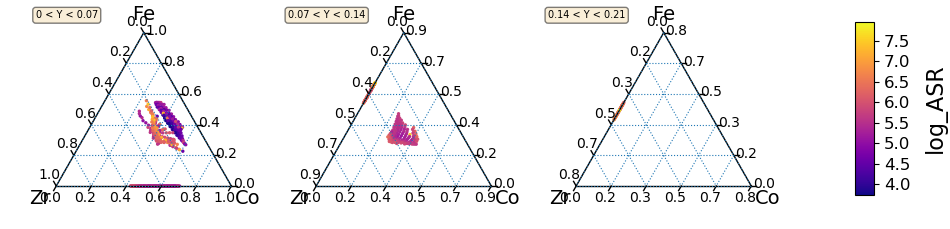

Scale: 0.965
Scale: 0.895
Scale: 0.825


<IPython.core.display.Javascript object>


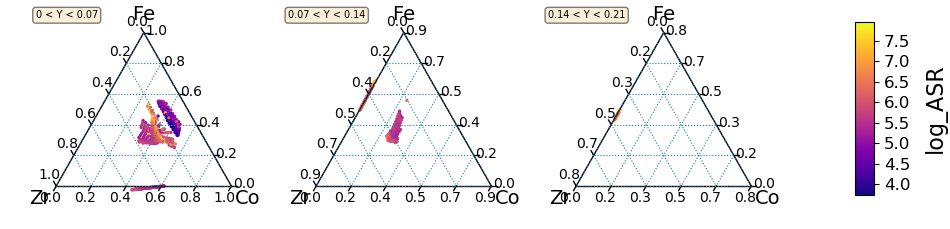

Scale: 0.965
Scale: 0.895
Scale: 0.825


<IPython.core.display.Javascript object>


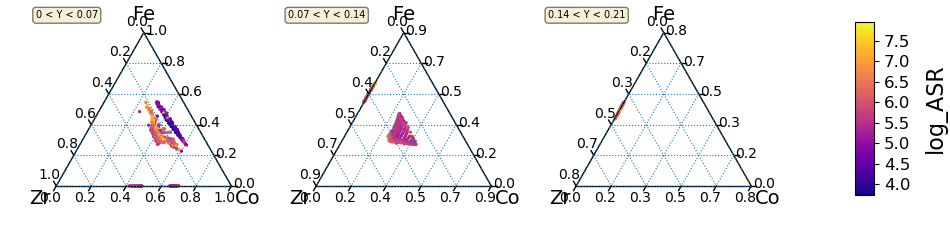

Scale: 0.965
Scale: 0.895
Scale: 0.825


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000244044C45F8>,
      dtype=object)

In [8]:
scatter_slices(data,'log_ASR',slice_axis='Y',tern_axes=['Co','Fe','Zr'], slice_starts=[0.,0.07,.14],slice_widths=0.07,ncols=3,
               cmap=plt.cm.plasma,ptsize=2,titlesize=7,figsize=(9.5,2.3))

scatter_slices(reconstructed,'log_ASR',slice_axis='Y',tern_axes=['Co','Fe','Zr'], slice_starts=[0.,0.07,.14],slice_widths=0.07,ncols=3,
               cmap=plt.cm.plasma,ptsize=2,titlesize=7,figsize=(9.5,2.3))

scatter_slices(kreconstructed,'log_ASR',slice_axis='Y',tern_axes=['Co','Fe','Zr'], slice_starts=[0.,0.07,.14],slice_widths=0.07,ncols=3,
               cmap=plt.cm.plasma,ptsize=2,titlesize=7,figsize=(9.5,2.3))

In [117]:
np.linalg.norm(reconstructed[comp_dims] - data[comp_dims],ord=2), np.linalg.norm(kreconstructed[comp_dims] - data[comp_dims],ord=2)

(0.7883670010997911, 0.15366402371632829)

In [9]:
err = reconstructed[comp_dims] - data[comp_dims]
sum(sum((err**2).values))**0.5

0.7883670010997913

<IPython.core.display.Javascript object>


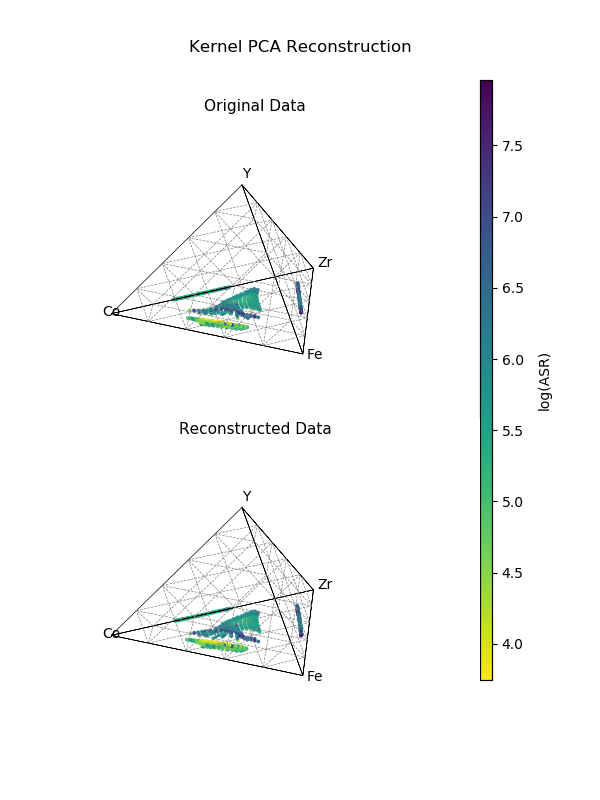

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0.95,'Kernel PCA Reconstruction')

In [160]:
fig = plt.figure(figsize=[6,8])
titles = ['Original Data','Reconstructed Data']
for i, df in enumerate([data, kreconstructed]):

    ax = fig.add_subplot(2,1,i+1,projection='3d')
    qax = QuaternaryAxes(ax=ax)
    qax.draw_axes(color='k',lw=0.5)
    qax.gridlines()
    qax.scatter(df.loc[:,['Co','Fe','Zr','Y']].values,c=df['log_ASR'],s=3,colorbar=True,cmap=plt.cm.viridis_r,
                cb_kwargs=dict(label='log(ASR)',labelkwargs={'labelpad':10},cbrect=[0.8,0.15,0.02,0.75]))
    qax.label_corners(['Co','Fe','Zr','Y'])
    #qax.axes_ticks()
    qax.ax.axis('off')
    qax.ax.set_title(titles[i],size=11)
    #qax.fill()
fig.subplots_adjust(hspace=0.1)
fig.suptitle('Kernel PCA Reconstruction',y=0.95)
#fig.tight_layout()

<IPython.core.display.Javascript object>


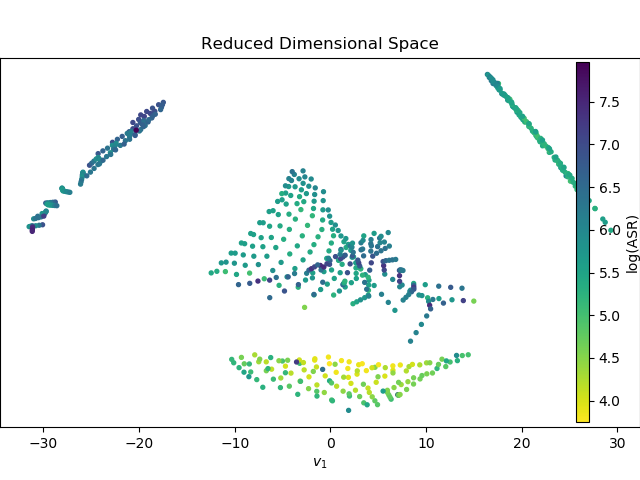

Text(0.5,1,'Reduced Dimensional Space')

In [64]:
fig, ax = plt.subplots()
ax.scatter(x=ktrans['v1'],y=ktrans['v2'],c=ktrans['log_ASR'],s=8,cmap=plt.cm.viridis_r)
add_colorbar(fig=fig,ax=ax,cmap=plt.cm.viridis_r,label='log(ASR)', vmin=ktrans['log_ASR'].min(),vmax=ktrans['log_ASR'].max(),
                subplots_adjust=dict(left=0.1,right=0.8),cbrect=[0.9,0.12,0.02,0.75])
ax.set_xlabel('$v_1$')
ax.set_ylabel('$v_2$')
ax.set_title('Reduced Dimensional Space')


Scale: 0.95
Scale: 0.85


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D3CA7C42E8>,
      dtype=object)

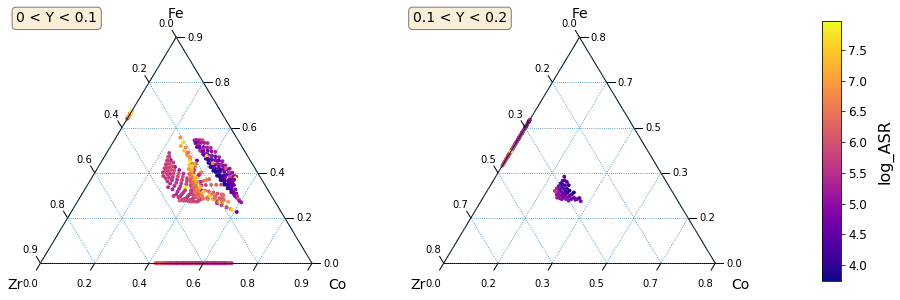

In [5]:
scatter_slices(data,'log_ASR',slice_axis='Y',tern_axes=['Co','Fe','Zr'], slice_starts=[0.,0.1],slice_widths=0.1,ncols=2,
               cmap=plt.cm.plasma, tick)



Scale: 0.825
Scale: 0.675
Scale: 0.5249999999999999


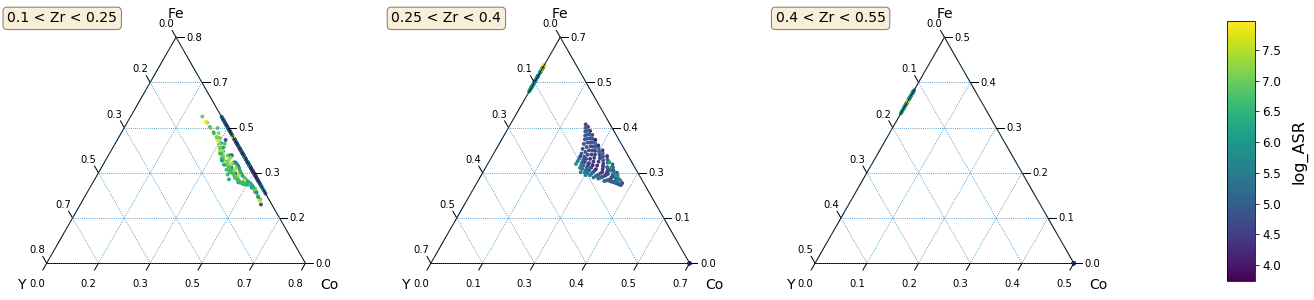

In [5]:
scatter_slices(data,'log_ASR',slice_axis='Zr',tern_axes=['Co','Fe','Y'], slice_starts=[0.1,0.25,0.4],slice_widths=0.15,ncols=3)

In [13]:
t = [1,2,3]
v = 0.1
u = [v]*3

for i, (a,b) in enumerate(zip(t,u)):
    print(i,a,b)

0 1 0.1
1 2 0.1
2 3 0.1


Scale: 0.95
Scale: 0.85


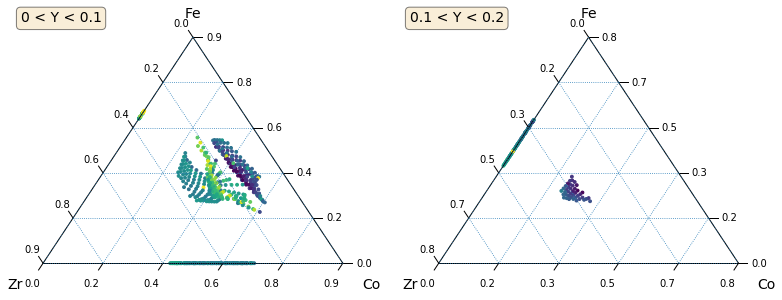

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002018D81C780>]],
      dtype=object)

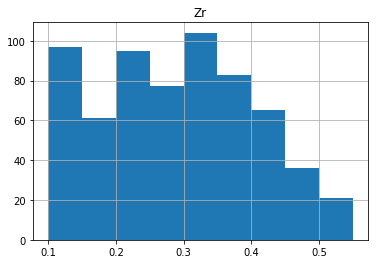

In [11]:
data.hist('Zr',bins=np.arange(0.1,0.6,0.05))

(3.7454714196568277, 7.9600956286668945)

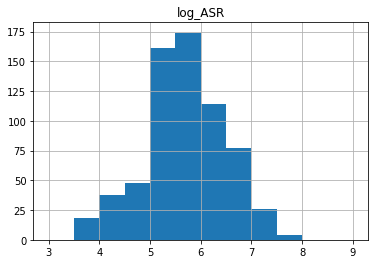

In [4]:
data.hist('log_ASR',bins=np.arange(3,9.5,0.5))
data['log_ASR'].min(),data['log_ASR'].max()

In [7]:
comp_dims = ['Ba','Co','Fe','Zr','Y']
out = flag_outliers(data,comp_dims,'log_ASR',z_thresh=1.5,full=True, db_kwargs=dict(eps=0.25))
data2 = data.join(out)

Scale: 0.95
Scale: 0.95
Scale: 0.85
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85


Text(0.5,1.1,'Outliers')

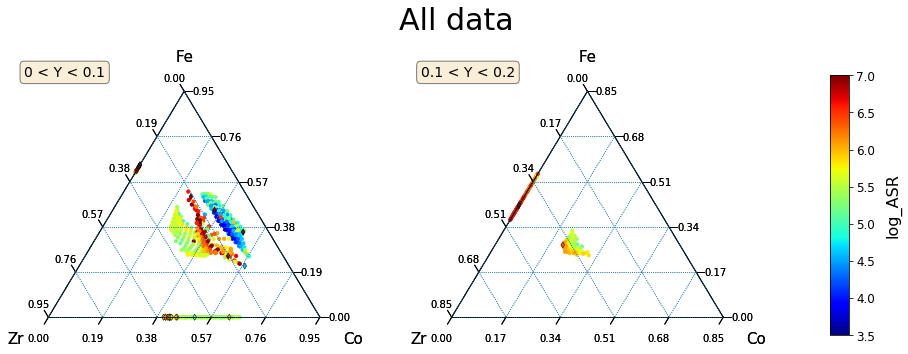

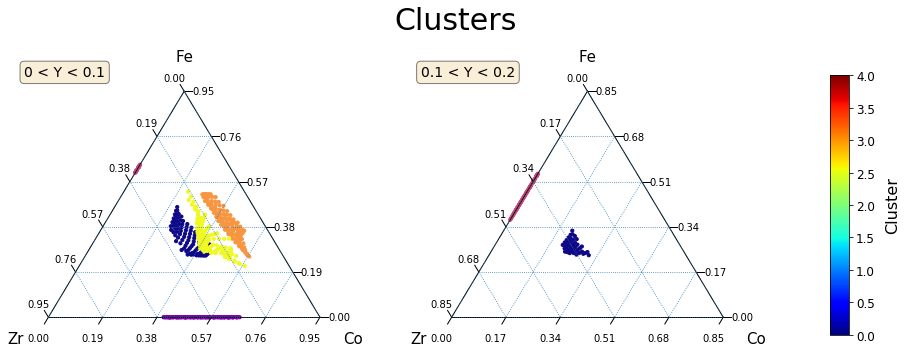

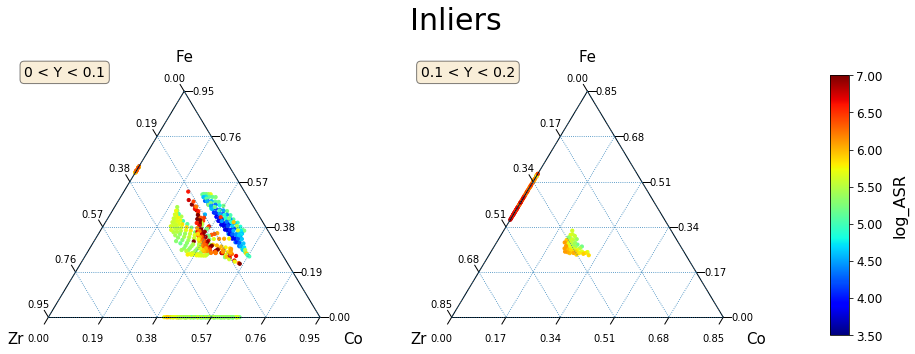

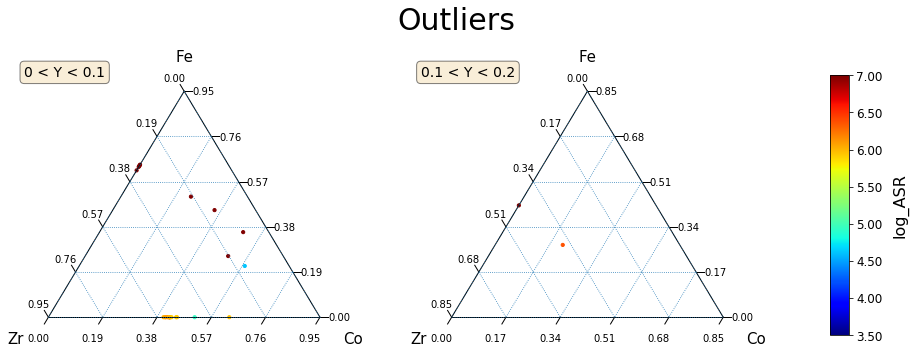

In [12]:
outliers = data2[data2['outlier_flag']==-1]
inliers = data2[data2['outlier_flag']==0]
prop = 'log_ASR'
cmap = plt.cm.jet

#ternary plots of all data with outliers outlined in red
vmin = 3.5
vmax = 7
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    
    quat_slice_scatter(inliers,z=prop,slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    try:
        quat_slice_scatter(outliers,z=prop,slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=20,nticks=5,  cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},
                      scatter_kw=dict(marker='d',edgecolors='k',linewidths=0.5))
    except ValueError:
        pass
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label=prop,labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cmap=cmap,
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('All data',size=30,y=1.1)

#ternary plots of all data with clusters identified
vmin = data2['cluster'].min()
vmax = data2['cluster'].max()
cmap_c = plt.cm.plasma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(data2,z='cluster',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5, cmap=cmap_c,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Cluster',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cmap=cmap,
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Clusters',size=30,y=1.1)

#ternary plots of inliers only - plot log_sigma
vmin = 3.5
vmax = 7
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    quat_slice_scatter(inliers,z=prop,slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label=prop,labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, cmap=cmap,
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Inliers',size=30,y=1.1)

#ternary plots of outliers only - plot log_sigma
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    
    try:
        quat_slice_scatter(outliers,z=prop,slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03},)
    
    except ValueError:
        ax.axis('off')
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label=prop,labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.2f',ax=axes, cmap=cmap,
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

fig.suptitle('Outliers',size=30,y=1.1)

Scale: 0.965
Scale: 0.895
Scale: 0.825


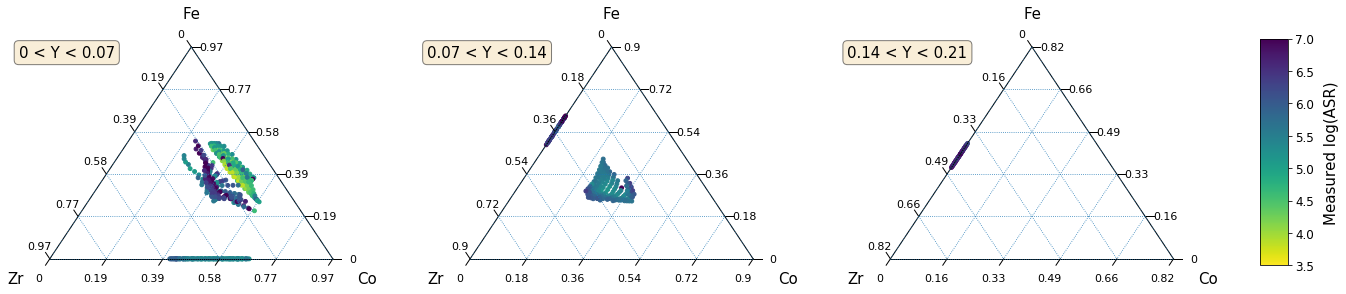

In [13]:
vmin = 3.5
vmax = 7
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0, 0.07, 0.14]
slice_width = 0.07
slice_axis='Y'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(data,z='log_ASR',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log(ASR)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
#plt.savefig(os.path.join(plotdir,'exp_ASR_sliceY.png'),dpi=500)

0.845
0.6950000000000001
0.5449999999999999


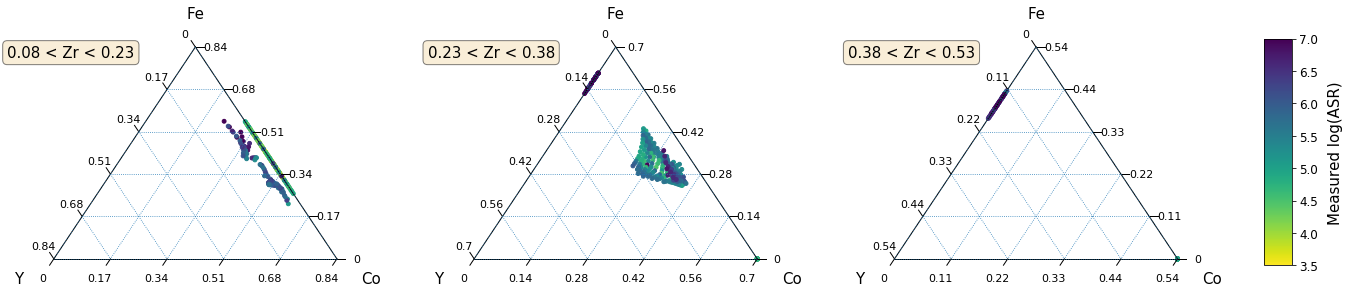

In [16]:
vmin = 3.5
vmax = 7
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0.08, 0.23, 0.38]
slice_width = 0.15
slice_axis='Zr'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(data,z='log_ASR',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Y'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5,cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log(ASR)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_ASR_sliceZr.png'),dpi=500)

In [58]:
data['log_ASR'].min(),data['log_ASR'].max()

(3.470808730148019, 8.829785655905795)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000248748C98D0>]],
      dtype=object)

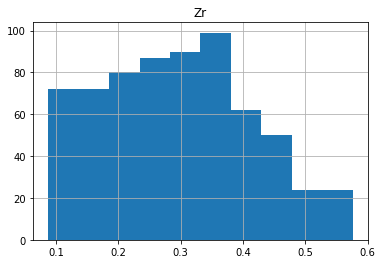

In [39]:
data.hist('Zr')

In [101]:
data[(data['T_set']=='500C')]

,ASR,Point,T_set,Temp_C,atm,formula,sample,x_mm,y_mm,Ba,Co,Fe,Y,Zr,O,log_ASR
1_500C_dryPDAC_COM3_01488,169614.590,1,500C,437,dry,Ba0.91162Co0.40788Fe0.30487Y0.05469Zr0.23256O3,PDAC_COM3_01488,0,0.00,0.911620,0.407880,0.304870,0.054690,0.232560,3.00000,5.229463
2_500C_dryPDAC_COM3_01488,214382.280,2,500C,437,dry,Ba0.90957Co0.37871Fe0.32098Y0.05549Zr0.24483O3,PDAC_COM3_01488,-4,0.00,0.909561,0.378706,0.320977,0.055489,0.244828,2.99997,5.331189
3_500C_dryPDAC_COM3_01488,569445.060,3,500C,437,dry,Ba0.91972Co0.35613Fe0.33813Y0.05609Zr0.24964O3,PDAC_COM3_01488,-8,0.00,0.919729,0.356134,0.338133,0.056091,0.249642,3.00003,5.755452
4_500C_dryPDAC_COM3_01488,588483.120,4,500C,437,dry,Ba0.91238Co0.33097Fe0.35299Y0.06109Zr0.25495O3,PDAC_COM3_01488,-12,0.00,0.912380,0.330970,0.352990,0.061090,0.254950,3.00000,5.769734
5_500C_dryPDAC_COM3_01488,551569.440,5,500C,437,dry,Ba0.91634Co0.30742Fe0.37091Y0.06435Zr0.25732O3,PDAC_COM3_01488,-16,0.00,0.916340,0.307420,0.370910,0.064350,0.257320,3.00000,5.741600
6_500C_dryPDAC_COM3_01488,455153.940,6,500C,437,dry,Ba0.91319Co0.28463Fe0.38397Y0.06837Zr0.26303O3,PDAC_COM3_01488,-20,0.00,0.913190,0.284630,0.383970,0.068370,0.263030,3.00000,5.658158
7_500C_dryPDAC_COM3_01488,347146.000,7,500C,437,dry,Ba0.913Co0.26403Fe0.39733Y0.06677Zr0.27187O3,PDAC_COM3_01488,-24,0.00,0.913000,0.264030,0.397330,0.066770,0.271870,3.00000,5.540512
8_500C_dryPDAC_COM3_01488,262687.410,8,500C,437,dry,Ba0.91131Co0.24899Fe0.41548Y0.06743Zr0.2681O3,PDAC_COM3_01488,-28,0.00,0.911310,0.248990,0.415480,0.067430,0.268100,3.00000,5.419439
9_500C_dryPDAC_COM3_01488,449593.310,9,500C,437,dry,Ba0.91218Co0.23455Fe0.42603Y0.06736Zr0.27207O3,PDAC_COM3_01488,-32,0.00,0.912171,0.234548,0.426026,0.067359,0.272067,2.99997,5.652820
10_500C_dryPDAC_COM3_01488,76736.539,10,500C,437,dry,Ba0.90631Co0.22283Fe0.44083Y0.06628Zr0.27006O3,PDAC_COM3_01488,-36,0.00,0.906310,0.222830,0.440830,0.066280,0.270060,3.00000,4.885002


## E_a

In [25]:
#load from pifs to avoid recalculating E_a from fits
pifdir = os.path.join(datadir,'pifs')

srcdir = os.path.join(pifdir,'ASR_Ea_Co(2,3)Fe(3,4)')
pifs = []
for file in glob.glob(os.path.join(srcdir,'*.json')):
    with open(file,'r') as f:
        fp = pypif.pif.load(f)
        pifs += fp

In [26]:
def conditionalprop_frompifs(pifs,conditionalprop,scalarprops=[]):
    """
    load conditional property from list of pifs. Each pif gets 1 row for each set of conditions
    ----------------------
    pifs: list of pifs
    conditionalprop: name of conditional property to load
    scalarprops: additional properties to load into dataframe. must be single-valued (non-conditional)
    """
    df = pd.DataFrame()
    for pif in pifs:
        pifdf = pd.DataFrame()
        pifdict = pif.as_dictionary()
        
        #conditional property - must be first since may have multiple values/conditions
        cproplist = [p for p in pifdict['properties'] if p['name']==conditionalprop]
        if len(cproplist) == 0:
            raise Exception('No property {}'.format(conditionalprop))
        elif len(cproplist) > 1:
            raise Exception('Multiple properties with name {}'.format(conditionalprop))
        else:
            propdict = cproplist[0]

        pifdf[conditionalprop] = propdict['scalars']
        for cond in propdict['conditions']:
            pifdf[cond['name']] = cond['scalars']
        
        #scalar props
        sprops = [p for p in pifdict['properties'] if p['name'] in scalarprops]
        for sp in sprops:
            pifdf[sp['name']] = sp['scalars']
        
        #ids and formula
        for pid in pifdict['ids']:
            pifdf[pid['name']] = pid['value']
        pifdf['formula'] = pif.chemical_formula
        
        df = df.append(pifdf)
        
    return df

In [27]:
cdf = conditionalprop_frompifs(pifs,'$E_a$',scalarprops=['Ba_amt','Co_amt','Fe_amt','Y_amt','Zr_amt'])
rename = {col:col[:-4] for col in cdf.columns if col[-4:]=='_amt'}
rename['$E_a$'] = 'E_a'
cdf.rename(columns=rename,inplace=True)

Scale: 0.965
Scale: 0.895
Scale: 0.825
---------
Dry
---------


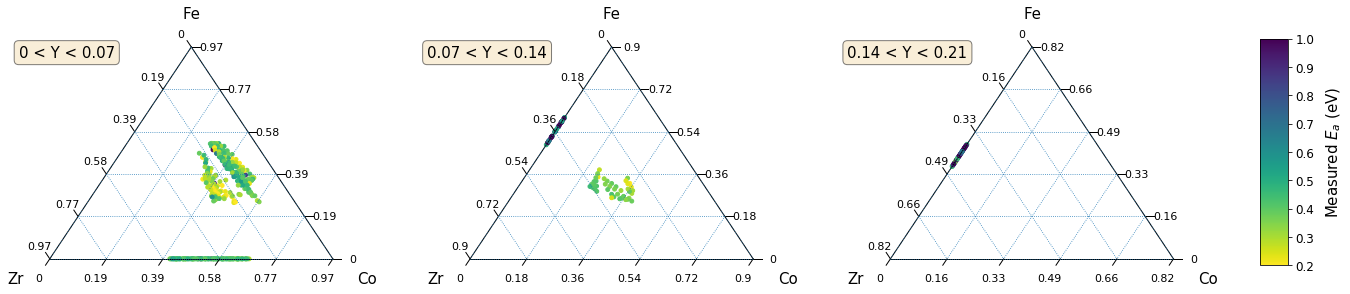

In [28]:
vmin = 0.2
vmax = 1
atm = 'dry'
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0, 0.07, 0.14]
slice_width = 0.07
slice_axis='Y'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    tdf = cdf.loc[cdf['Atmosphere']==atm,:]
    
    quat_slice_scatter(tdf,z='E_a',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $E_a$ (eV)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_dry_Ea_sliceY.png'),dpi=500)
print('---------\nDry\n---------')

0.965
0.895
0.825
---------
Wet
---------


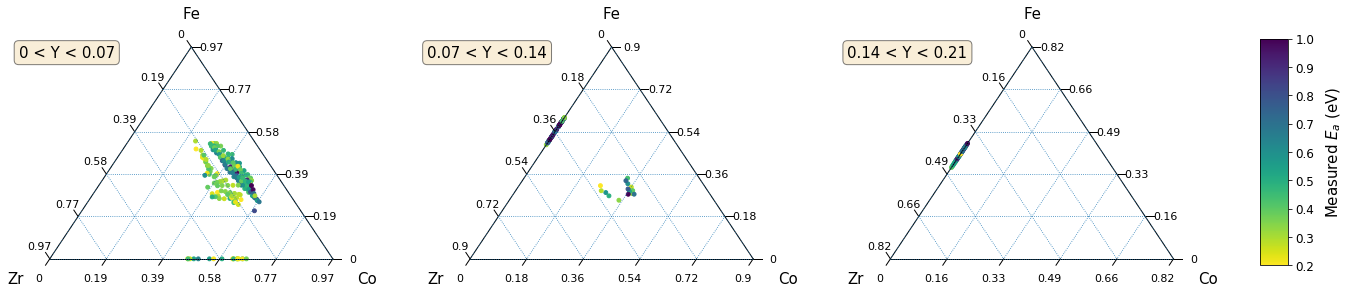

In [110]:
vmin = 0.2
vmax = 1
atm = 'wet'
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0, 0.07, 0.14]
slice_width = 0.07
slice_axis='Y'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    tdf = cdf.loc[cdf['Atmosphere']==atm,:]
    
    quat_slice_scatter(tdf,z='E_a',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $E_a$ (eV)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_wet_Ea_sliceY.png'),dpi=500)
print('---------\nWet\n---------')

0.845
0.6950000000000001
0.5449999999999999
---------
Dry
---------


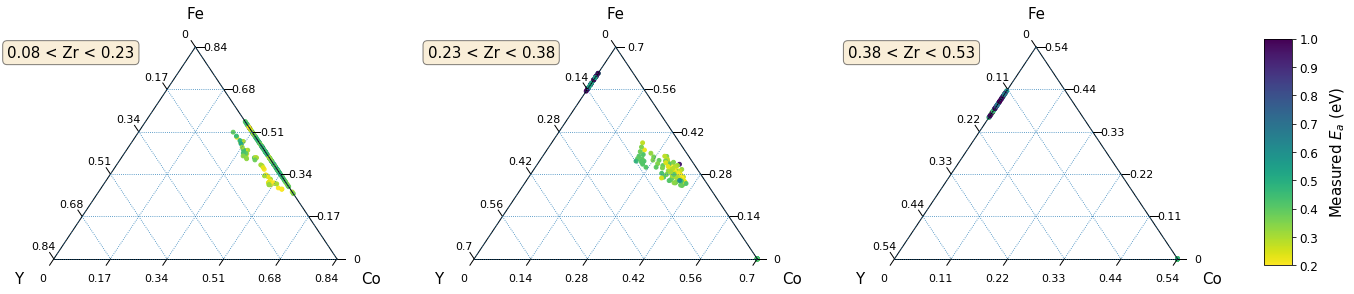

In [111]:
vmin = 0.2
vmax = 1
atm = 'dry'
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0.08, 0.23, 0.38]
slice_width = 0.15
slice_axis='Zr'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    tdf = cdf.loc[cdf['Atmosphere']==atm,:]
    
    quat_slice_scatter(tdf,z='E_a',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Y'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $E_a$ (eV)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_dry_Ea_sliceZr.png'),dpi=500)
print('---------\nDry\n---------')

0.845
0.6950000000000001
0.5449999999999999
---------
Wet
---------


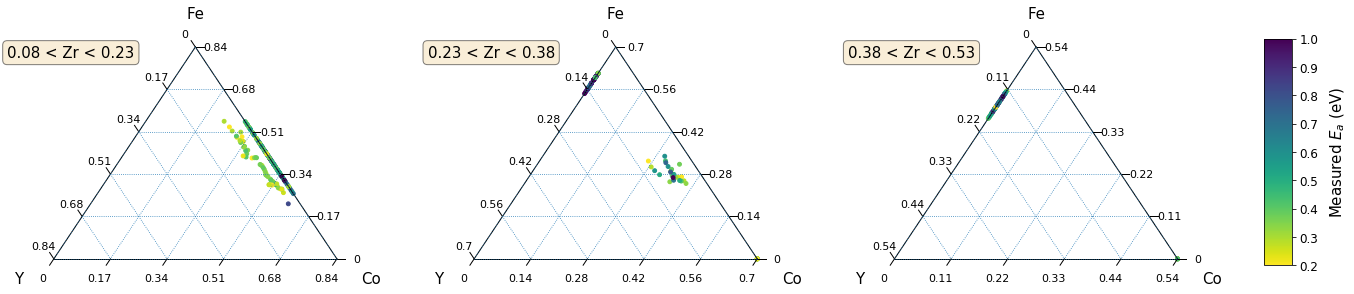

In [112]:
vmin = 0.2
vmax = 1
atm = 'wet'
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0.08, 0.23, 0.38]
slice_width = 0.15
slice_axis='Zr'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    tdf = cdf.loc[cdf['Atmosphere']==atm,:]
    
    quat_slice_scatter(tdf,z='E_a',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Y'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $E_a$ (eV)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_wet_Ea_sliceZr.png'),dpi=500)
print('---------\nWet\n---------')

In [90]:
tmp = cdf[(cdf['Y']<=0.025) & (cdf['Zr'] < 0.2)]
tw = tmp[tmp['Atmosphere']=='wet']
td = tmp[tmp['Atmosphere']=='dry']
#tmp['Atmosphere'].map({'dry':0,'wet':1}).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A94D1FB5C0>]],
      dtype=object)

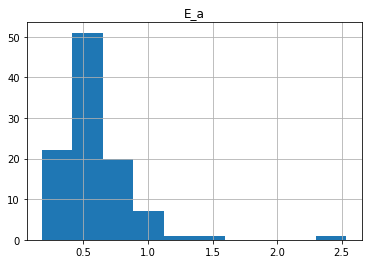

In [91]:
tw.hist('E_a')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A94D314A20>]],
      dtype=object)

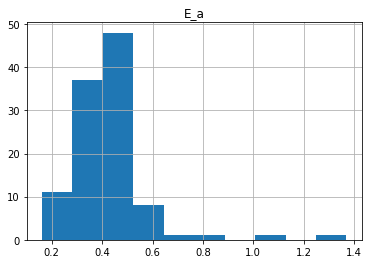

In [92]:
td.hist('E_a')

In [126]:
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl

def z_score(x):
    mu = np.mean(x)
    std = np.std(x)
    return (x-mu)/std

class DataCleaner():
    """
    Class for outlier detection and data cleaning in preprocessing
    Implements sklearn.cluster.DBSCAN for compositional clustering, 
    and sklearn.ensemble.IsolationForest for greedy outlier flagging.
    Applies z-score threshold within composition clusters to screen 
    IsolationForest flags.
    
    Parameters
    ----------
    data: dataset to process (pandas DataFrame)
    prop_dim: property dimension to screen for outliers
    comp_dims: composition dimensions for clustering and IsolationForest
    DB_kw: kwargs to pass to DBSCAN instantiation
    IF_kw: kwargs to pass to IsolationForest instantiation
    """
    def __init__(self, data, prop_dim, comp_dims=None, DB_kw={},IF_kw={}):
        self.data = data
        self.set_prop_dim(prop_dim)
        self.set_comp_dims(comp_dims)
        self.random_state = np.random.RandomState(17)
        self.db = DBSCAN(**DB_kw)
        self.clf = IsolationForest(random_state=self.random_state,**IF_kw)
                 
    def set_prop_dim(self,prop_dim):
        "set property dimension"
        self._prop_dim = prop_dim
    
    def get_prop_dim(self):
        "get property dimension"
        return self._prop_dim
    
    prop_dim = property(get_prop_dim,set_prop_dim)
    
    def set_comp_dims(self,comp_dims=None):
        """
        set composition dimensions used for clustering. Defaults to all valid elemental symbols in data columns
        
        Parameters
        ----------
        comp_dims: list of columns in data to use as composition dimensions
        """
        #if no comp dims specified, use all columns that are valid element symbols
        if comp_dims==None:
            comp_dims = []
            for col in self.data.columns:
                try: 
                    mg.Element(col)
                    comp_dims.append(col)
                except ValueError:
                    pass
        self._comp_dims = comp_dims
        
    def get_comp_dims(self):
        "get composition dimensions"
        return self._comp_dims
    
    comp_dims = property(get_comp_dims,set_comp_dims)
    
    @property 
    def comp_data(self):
        "composition data"
        return self.data[self.comp_dims]
    
    @property
    def iso_dims(self):
        "dimensions used by IsolationForest"
        return self.comp_dims + [self.prop_dim]
    
    @property
    def iso_data(self):
        "data used by IsolationForest"
        return self.data[self.iso_dims]
    
    def scale_composition(self,max_var=1):
        """
        scale composition dimensions such that largest-variance dimension has variance max_var
        """
        ss = StandardScaler()
        #get dimension with largest variance
        ref_dim = np.var(self.comp_data).idxmax()
        ss.fit(self.comp_data[ref_dim].values[:,None])
        #scale all comp dims with same scaler such that refdim has variance max_var
        self.scaled_comp_data = pd.DataFrame((max_var**0.5)*ss.transform(self.comp_data),columns=self.comp_dims)
        
    def fit(self, comp_scale=1):
        """
        fit DBSCAN and IsolationForest to data
        
        Parameters
        ----------
        comp_scale: maximum compositional variance set by scale_composition
        """
        self.scale_composition(max_var=comp_scale)
        self.db.fit(self.scaled_comp_data) #fit DBSCAN to comp data for compositional clustering
        self.clf.fit(self.iso_data) #fit IsolationForest to iso data for greedy outlier flagging
                 
    def predict(self,z_thresh=2):
        """
        predict outliers in data
        
        Parameters
        ----------
        z_thresh: z-score threshold for intra-cluster outlier identification
        """
        self.pred = pd.DataFrame()
        self.pred[self.prop_dim] = self.data[self.prop_dim]
        self.pred.loc[:,'cluster'] = self.db.fit_predict(self.scaled_comp_data) #db has no pure predict function
        
        self.pred.loc[:,'isolation_flag'] = self.clf.predict(self.iso_data)
        self.pred.loc[:,'isolation_score'] = self.clf.decision_function(self.iso_data)

        #get z-scores for each cluster and cross-ref with isolation forest
        for i, cluster in enumerate(self.pred['cluster'].unique()):
            df = self.pred.loc[self.pred['cluster']==cluster,:]
            self.pred.loc[self.pred['cluster']==cluster,'cluster_zscore'] = z_score(df[self.prop_dim])

        #set final outlier flag - if flagged by isolation forest and cluster z-score is outside z_thresh
        self.pred.loc[:,'outlier_flag'] = np.where(
                                            (self.pred['isolation_flag']==-1) & (np.abs(self.pred['cluster_zscore']) > z_thresh),
                                            -1, 0)
        
        return self.pred
        
    def fit_predict(self,comp_scale=1,z_thresh=2):
        """combine fit and predict functions"""
        self.fit(comp_scale=comp_scale)
        self.predict(z_thresh=z_thresh)
        return self.pred
    
    def remove_outliers(self):
        """remove outliers identified by fit_predict"""
        self.clean_data = self.data[self.pred['outlier_flag']!=-1]
        return self.clean_data
    
    @property
    def data_pred(self):
        "data joined with prediction results"
        return self.data.join(self.pred.drop(labels=self.prop_dim, axis=1))
    
    @property
    def outliers(self):
        "outlier data rows"
        return self.data_pred[self.data_pred['outlier_flag']==-1]
    
    @property
    def inliers(self):
        "inlier data rows"
        return self.data_pred[self.data_pred['outlier_flag']!=-1]
    
    def set_DB_params(self,**params):
        """set DBSCAN parameters"""
        self.db.set_params(**params)
    
    def set_IF_params(self,**params):
        """set IsolationForest parameters"""
        self.clf.set_params(**params)
        
    def highlight_outliers(self, slice_axis, slice_starts, slice_widths, tern_axes,cmap=plt.cm.viridis,**scatter_kwargs):
        """
        plot all data points with outliers highlighted in red. color determined by value of prop_dim
        
        Parameters
        ----------
        slice_axis: composition dimension on which to slice
        slice_starts: values of slice_axis at which to start slices
        slice_widths: widths of slices in slice_axis dimension. Single value or list
        tern_axes: composition dimensions for ternary plot axes (order: right, top, left)
        cmap: colormap for prop_dim values
        scatter_kwargs: kwargs to pass to helpers.plotting.scatter_slices
        """
        #plot inliers
        axes = scatter_slices(self.inliers,self.prop_dim,slice_axis,slice_starts,slice_widths,tern_axes,cmap=cmap,**scatter_kwargs)
        #plot outliers
        scatter_slices(self.outliers,self.prop_dim,slice_axis,slice_starts,slice_widths,tern_axes,cmap=cmap,axes=axes,
                       ptsize=20,scatter_kw=dict(marker='d',edgecolors='r',linewidths=0.8),**scatter_kwargs)
        
    def plot_clusters(self, slice_axis, slice_starts, slice_widths, tern_axes, cmap=plt.cm.jet,**scatter_kwargs):
        """
        plot all data points with cluster shown by color
        
        Parameters
        ----------
        slice_axis: composition dimension on which to slice
        slice_starts: values of slice_axis at which to start slices
        slice_widths: widths of slices in slice_axis dimension. Single value or list
        tern_axes: composition dimensions for ternary plot axes (order: right, top, left)
        cmap: colormap for cluster values
        scatter_kwargs: kwargs to pass to helpers.plotting.scatter_slices
        """
        scatter_slices(self.data_pred,'cluster',slice_axis,slice_starts,slice_widths,tern_axes,cmap=cmap,**scatter_kwargs)
        
    def plot_outliers(self, slice_axis, slice_starts, slice_widths, tern_axes, cmap=plt.cm.viridis,**scatter_kwargs):
        """
        plot outliers only
        
        Parameters
        ----------
        slice_axis: composition dimension on which to slice
        slice_starts: values of slice_axis at which to start slices
        slice_widths: widths of slices in slice_axis dimension. Single value or list
        tern_axes: composition dimensions for ternary plot axes (order: right, top, left)
        cmap: colormap for prop_dim values
        scatter_kwargs: kwargs to pass to helpers.plotting.scatter_slices
        """
        scatter_slices(self.outliers,self.prop_dim,slice_axis,slice_starts,slice_widths,tern_axes,cmap=cmap,**scatter_kwargs)
        
    def plot_inliers(self, slice_axis, slice_starts, slice_widths, tern_axes, cmap=plt.cm.viridis,**scatter_kwargs):
        """
        plot inliers only
        
        Parameters
        ----------
        slice_axis: composition dimension on which to slice
        slice_starts: values of slice_axis at which to start slices
        slice_widths: widths of slices in slice_axis dimension. Single value or list
        tern_axes: composition dimensions for ternary plot axes (order: right, top, left)
        cmap: colormap for prop_dim values
        scatter_kwargs: kwargs to pass to helpers.plotting.scatter_slices
        """
        scatter_slices(self.inliers,self.prop_dim,slice_axis,slice_starts,slice_widths,tern_axes,cmap=cmap,**scatter_kwargs)
    
    def cluster_hist(self,ncols=2):
        
        clusters = self.pred['cluster'].unique()
        print(clusters)
        nrows = int(np.ceil(len(clusters)/ncols))
        print(nrows)
        fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*6,nrows*4))
        for i, cluster in enumerate(clusters):
            df = self.data_pred.loc[self.data_pred['cluster']==cluster,:]

            num_outliers = len(df[df['isolation_flag']==-1])
            try: #2d axes
                ax = axes[int(i/ncols), i%ncols]
            except IndexError: #1d axes
                ax = axes[i]
                
            dfo = df[df['isolation_flag']==-1]
            dfi = df[df['isolation_flag']==1]
            hist, bins = np.histogram(df['cluster_zscore'])
            ax.hist(dfi['cluster_zscore'],alpha=0.5,bins=bins,label='IsolationForest inliers')
            ax.hist(dfo['cluster_zscore'],alpha=0.5,bins=bins, label='IsolationForest outliers')
            ax.set_title(f'Cluster {cluster}')
            ax.set_xlabel('Cluster Z-score')
            ax.set_ylabel('Frequency')
            ax.legend()
        fig.tight_layout()
        
    def quat_highlight(self,quat_axes=['Co','Fe','Zr','Y'], gridlines=True, **scatter_kw):
        qax = QuaternaryAxes()
        qax.draw_axes()
        qax.label_corners(quat_axes)
        vmin = min(self.inliers[self.prop_dim].min(),self.outliers[self.prop_dim].min())
        vmax = min(self.inliers[self.prop_dim].max(),self.outliers[self.prop_dim].max())
        
        qax.scatter(self.inliers[quat_axes].values,c=self.inliers[self.prop_dim],s=3, vmin=vmin, vmax=vmax, 
                    colorbar=True, cb_kwargs={'label':self.prop_dim}, **scatter_kw)
        qax.scatter(self.outliers[quat_axes].values,c=self.outliers[self.prop_dim],s=6, vmin=vmin, vmax=vmax,
                    edgecolors='r',linewidths=0.5, **scatter_kw)
        
        qax.axes_ticks()
        if gridlines==True:
            qax.gridlines()
        qax.ax.axis('off')
    
        return qax
    
    def quat_clusters(self,ax=None,quat_axes=['Co','Fe','Zr','Y'], gridlines=True, cmap=plt.cm.plasma,s=3, 
                      label_kw={},**scatter_kw):
        qax = QuaternaryAxes(ax=ax)
        qax.draw_axes()
        qax.label_corners(quat_axes,**label_kw)
        vmin = self.pred['cluster'].min()
        vmax = self.pred['cluster'].max()
        
        #make norm for discrete colormap
        clusters = self.pred['cluster'].unique()
        n_clusters = len(self.pred['cluster'].unique())
        bounds = np.arange(clusters.min()-0.5,clusters.max()+0.51)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
        qax.scatter(self.data[quat_axes].values,c=self.pred['cluster'],s=s, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                    colorbar=True, cb_kwargs={'label':'Cluster','norm':norm,'ticks':clusters}, **scatter_kw)
        
        qax.axes_ticks()
        if gridlines==True:
            qax.gridlines()
        #qax.ax.axis('off')
        return qax
    
    def reduce_comp_dims(self,kernel='poly',gamma=10,**kpca_kw):
        comp_dims = self.comp_dims.copy()
        comp_dims.remove('O')
        comp_dims.remove('Ba')
        print(comp_dims)
        reconstructed = self.data[comp_dims].copy()
        kpca = KernelPCA(kernel=kernel,n_components=2,fit_inverse_transform=True,gamma=gamma,**kpca_kw)

        self.reduced = pd.DataFrame(kpca.fit_transform(self.data[comp_dims]),columns=['v1','v2'])
        reconstructed[comp_dims] = kpca.inverse_transform(self.reduced)

        self.reduced[self.prop_dim] = self.data[self.prop_dim].values
        self.reduced['outlier_flag'] = self.pred['outlier_flag'].values
        self.reduced['cluster'] = self.pred['cluster'].values
        
        error = np.linalg.norm(self.data[comp_dims] - reconstructed,ord=2)
        
        return self.reduced, error
    
    def reduced_plot(self,cmap=plt.cm.viridis,vmin=None,vmax=None,**kwargs):
        """
        scatter plot of prop_dim in reduced-dimension composition space
        
        Args:
        -----
        kwargs: kwargs to pass to plt.scatter
        """
        fig, ax = plt.subplots()
        if vmin is None:
            vmin = self.reduced[self.prop_dim].min()
        if vmax is None:
            vmax = self.reduced[self.prop_dim].max()
        
        ax.scatter(self.reduced['v1'],self.reduced['v2'],c=self.reduced[self.prop_dim],cmap=cmap,vmin=vmin,vmax=vmax,**kwargs)
        add_colorbar(fig=fig,ax=ax,cmap=cmap,label=self.prop_dim, vmin=vmin,vmax=vmax,
                subplots_adjust=dict(left=0.1,right=0.8),cbrect=[0.88,0.12,0.02,0.75])
        ax.set_xlabel('$v_1$')
        ax.set_ylabel('$v_2$')
    
    def reduced_highlight_plot(self,cmap=plt.cm.viridis,vmin=None,vmax=None,**kwargs):
        """
        scatter plot of prop_dim in reduced-dimension composition space with outliers highlighted in red
        
        Args:
        -----
        kwargs: kwargs to pass to plt.scatter
        """
        outliers = self.reduced.loc[self.reduced['outlier_flag']==-1,:]
        inliers = self.reduced.loc[self.reduced['outlier_flag']!=-1,:]
        
        fig, ax = plt.subplots()
        if vmin is None:
            vmin = self.reduced[self.prop_dim].min()
        if vmax is None:
            vmax = self.reduced[self.prop_dim].max()
            
        ax.scatter(inliers['v1'],inliers['v2'],c=inliers[self.prop_dim],cmap=cmap,vmin=vmin,vmax=vmax,s=8,**kwargs)
        ax.scatter(outliers['v1'],outliers['v2'],c=outliers[self.prop_dim],cmap=cmap,vmin=vmin,vmax=vmax,s=16,
                   edgecolors='r', linewidths=0.7, **kwargs)
        add_colorbar(fig=fig,ax=ax,cmap=cmap,label=self.prop_dim, vmin=vmin,vmax=vmax,
                subplots_adjust=dict(left=0.1,right=0.8),cbrect=[0.88,0.12,0.02,0.75])
        ax.set_xlabel('$v_1$')
        ax.set_ylabel('$v_2$')
        
        return ax
        
    def reduced_inlier_plot(self,cmap=plt.cm.viridis,vmin=None,vmax=None,**kwargs):
        inliers = self.reduced.loc[self.reduced['outlier_flag']!=-1,:]
        
        fig, ax = plt.subplots()
        if vmin is None:
            vmin = self.reduced[self.prop_dim].min()
        if vmax is None:
            vmax = self.reduced[self.prop_dim].max()
            
        ax.scatter(inliers['v1'],inliers['v2'],c=inliers[self.prop_dim],cmap=cmap,vmin=vmin,vmax=vmax,**kwargs)
        add_colorbar(fig=fig,ax=ax,cmap=cmap,label=self.prop_dim, vmin=vmin,vmax=vmax,
                subplots_adjust=dict(left=0.1,right=0.8),cbrect=[0.88,0.12,0.02,0.75])
        ax.set_xlabel('$v_1$')
        ax.set_ylabel('$v_2$')
        
        return ax
        
    def reduced_outlier_plot(self,cmap=plt.cm.viridis,vmin=None,vmax=None,**kwargs):
        """
        scatter plot of prop_dim in reduced-dimension composition space with outliers highlighted in red
        
        Args:
        -----
        kwargs: kwargs to pass to plt.scatter
        """
        outliers = self.reduced.loc[self.reduced['outlier_flag']==-1,:]
        
        fig, ax = plt.subplots()
        if vmin is None:
            vmin = self.reduced[self.prop_dim].min()
        if vmax is None:
            vmax = self.reduced[self.prop_dim].max()
            
        ax.scatter(outliers['v1'],outliers['v2'],c=outliers[self.prop_dim],cmap=cmap,vmin=vmin,vmax=vmax,**kwargs)
        add_colorbar(fig=fig,ax=ax,cmap=cmap,label=self.prop_dim, vmin=vmin,vmax=vmax,
                subplots_adjust=dict(left=0.1,right=0.8),cbrect=[0.88,0.12,0.02,0.75])
        ax.set_xlabel('$v_1$')
        ax.set_ylabel('$v_2$')
        
        return ax
    
    def reduced_cluster_plot(self, cmap=plt.cm.plasma, **kwargs):
                
        vmin = self.pred['cluster'].min()
        vmax = self.pred['cluster'].max()
        
        #make norm for discrete colormap
        clusters = self.pred['cluster'].unique()
        n_clusters = len(self.pred['cluster'].unique())
        bounds = np.arange(clusters.min()-0.5,clusters.max()+0.51)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
        fig, ax = plt.subplots()
        ax.scatter(self.reduced['v1'],self.reduced['v2'],c=self.reduced['cluster'],cmap=cmap,norm=norm, **kwargs)
        ax.set_xlabel('$v_1$')
        ax.set_ylabel('$v_2$')
        
        add_colorbar(fig=fig,ax=ax,cmap=cmap,norm=norm,label='Cluster',ticks=clusters,
                     subplots_adjust=dict(left=0.1,right=0.8),cbrect=[0.9,0.12,0.02,0.75])
        
        return ax
        



In [127]:
dc = DataCleaner(data,prop_dim='log_ASR',DB_kw=dict(eps=0.25))
dc.fit_predict(z_thresh=1.5)
dc.remove_outliers()
len(dc.clean_data), len(dc.data)

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(639, 660)

['Co', 'Fe', 'Y', 'Zr']


<IPython.core.display.Javascript object>


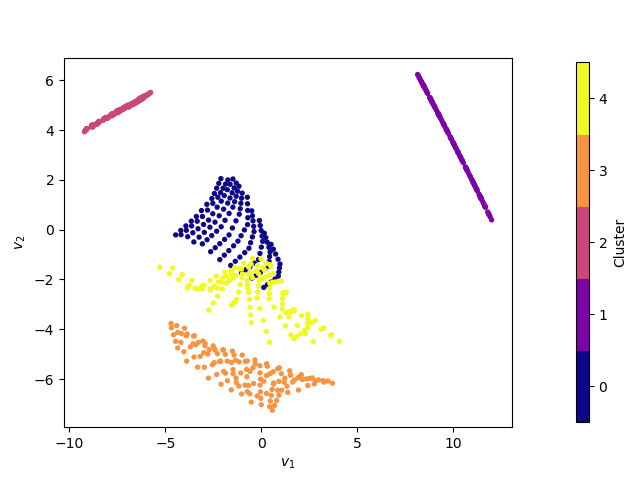

In [130]:
dc.reduce_comp_dims()
dc.reduced_cluster_plot(s=8)

<IPython.core.display.Javascript object>


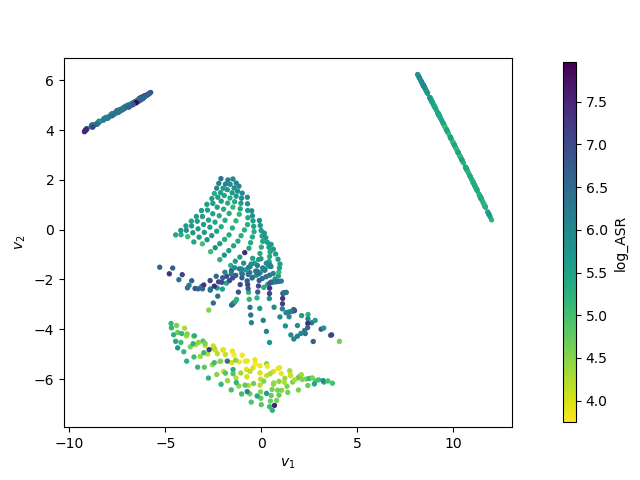

<IPython.core.display.Javascript object>


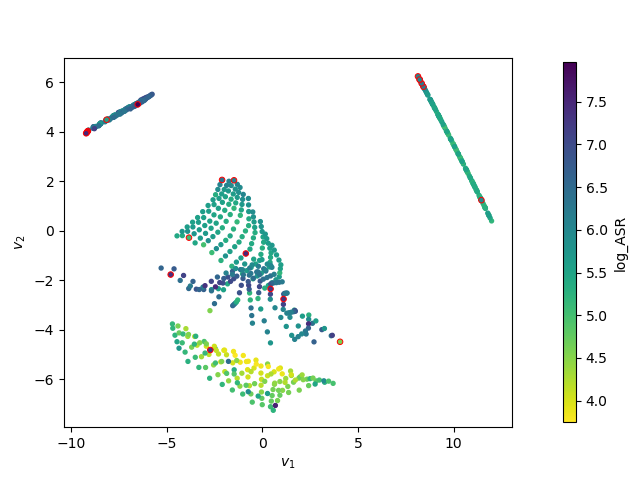

<IPython.core.display.Javascript object>


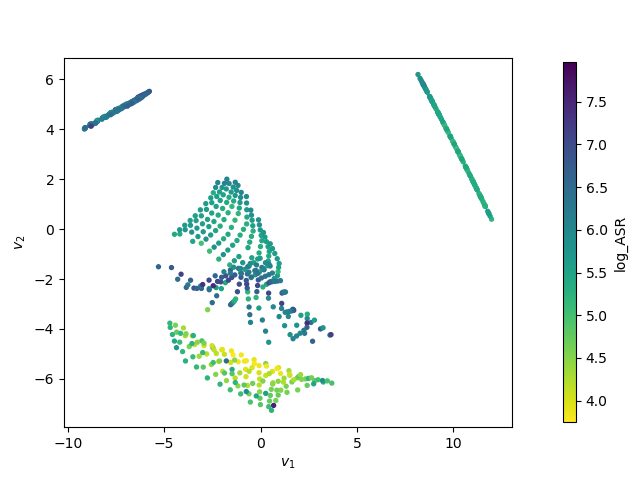

<IPython.core.display.Javascript object>


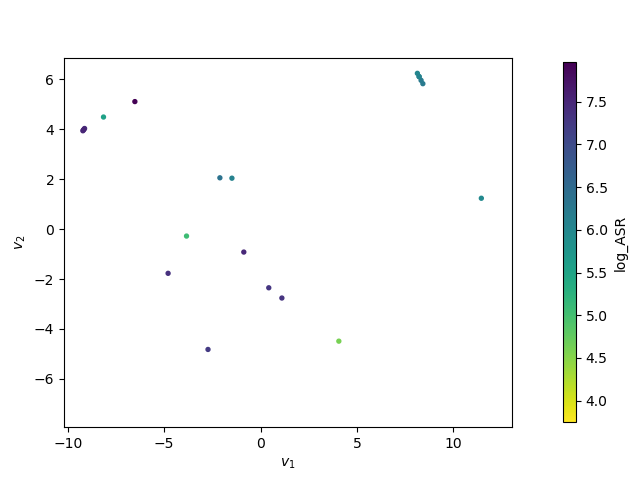

(-7.932640753283946, 6.866991799837672)

In [131]:
dc.reduced_plot(s=8,cmap=plt.cm.viridis_r)
dc.reduced_highlight_plot(cmap=plt.cm.viridis_r)
axi = dc.reduced_inlier_plot(s=8,cmap=plt.cm.viridis_r)
axo = dc.reduced_outlier_plot(s=8,cmap=plt.cm.viridis_r)
axo.set_xlim(axi.get_xlim())
axo.set_ylim(axi.get_ylim())

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


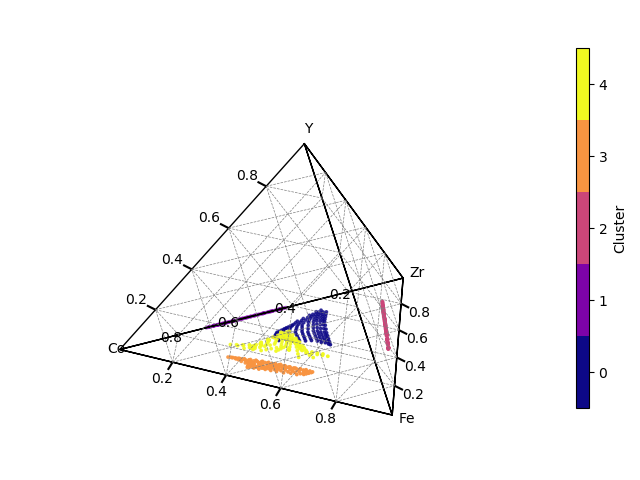

In [138]:
qax=dc.quat_clusters()
qax.ax.axis('off')
qax.fill()

<IPython.core.display.Javascript object>


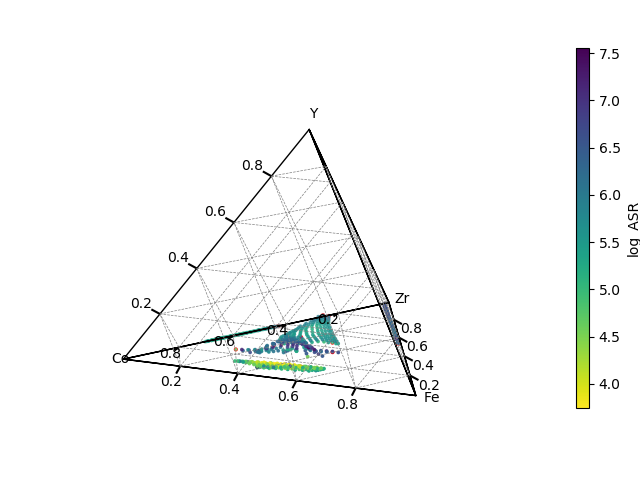

In [136]:
qax = dc.quat_highlight(cmap=plt.cm.viridis_r)
qax.fill()
qax.ax.axis('off')
fig.subplots_adjust(wspace=0,left=0,right=1)

[0 1 2 3 4]
3


<IPython.core.display.Javascript object>


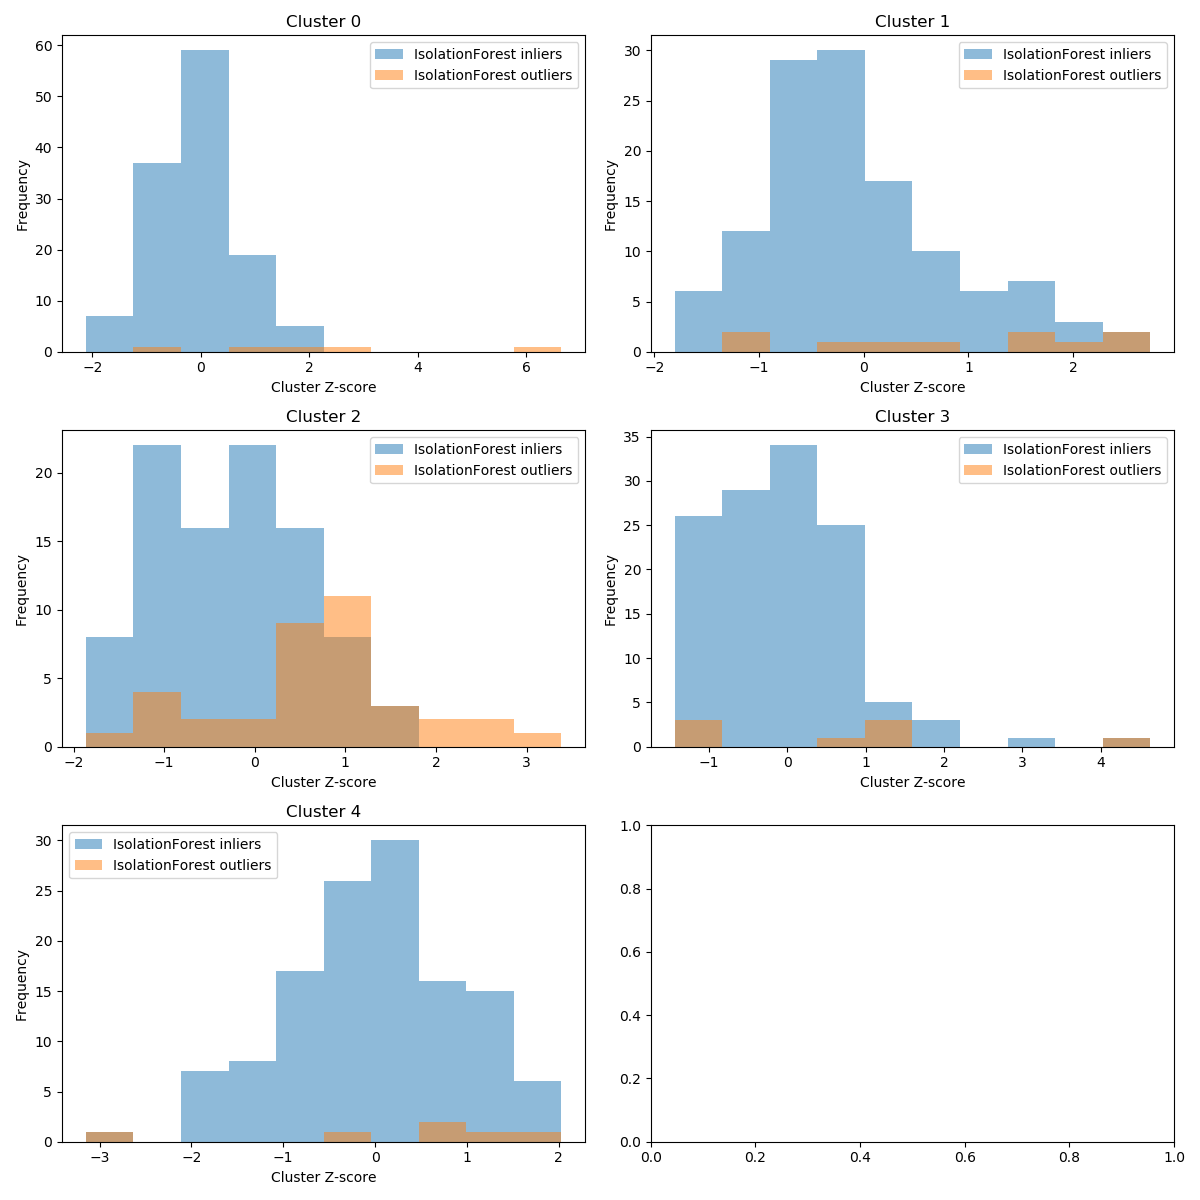

In [188]:
dc.cluster_hist()

In [ ]:
dc.

<IPython.core.display.Javascript object>


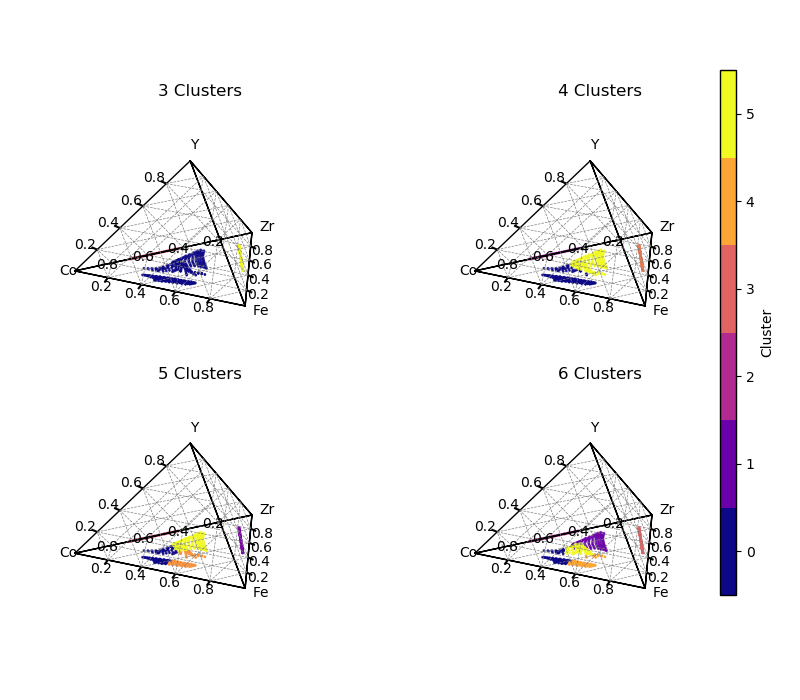

C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\jdhuang\AppDa

In [135]:
from sklearn.cluster import KMeans

dims = dc.comp_dims 

km = KMeans()

fig = plt.figure(figsize=[8,7])

for i, nc in enumerate([3,4,5,6]):
    km.set_params(n_clusters=nc)
    ax = fig.add_subplot(2,2,i+1,projection='3d')
    dc.pred['cluster'] = km.fit_predict(dc.data[dims])

    qax = dc.quat_clusters(ax=ax,s=1,label_kw=dict(offset=0.1))
    #qax.fill()
    qax.ax.axis('off')
    ax.set_title(f'{nc} Clusters')
    ax.patch.set_alpha(0.)
fig.subplots_adjust(wspace=0,left=0,right=1,hspace=0.1)

<IPython.core.display.Javascript object>


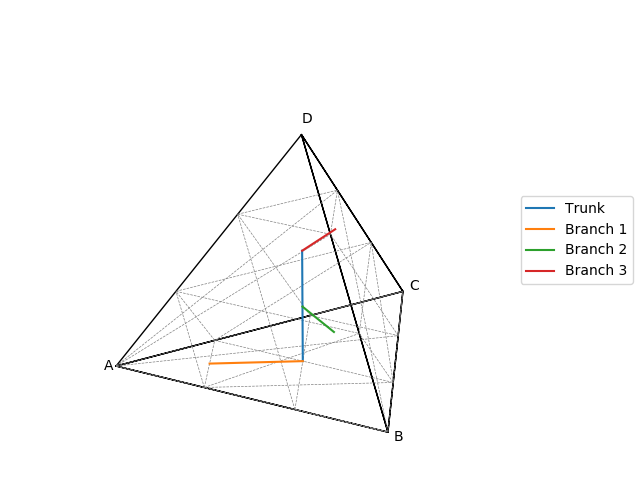

In [158]:
qax = QuaternaryAxes()
qax.draw_axes()
qax.label_corners(['A','B','C','D'])
qax.ax.axis('off')
trunk = [[1/3,1/3,1/3,0],[1/6,1/6,1/6,1/2]]
branch1 = [[1/3,1/3,1/3,0],[2/3,1/6,1/6,0]]
branch2 = [[1/4,1/4,1/4,1/4],[1/8,1/2,1/8,1/4]]
branch3 = [[1/6,1/6,1/6,1/2],[1/16,1/16,3/8,1/2]]
qax.gridlines(multiple=1/3)
qax.plot(trunk,label='Trunk')
qax.plot(branch1,label='Branch 1')
qax.plot(branch2,label='Branch 2')
qax.plot(branch3,label='Branch 3')
qax.ax.legend(loc='right')
qax.fill()

In [17]:
cmap = cmap.from_list('Custom',cmaplist,cmap.N)

In [24]:
import matplotlib as mpl
ncolors = 10
bounds = np.arange(0,ncolors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

<IPython.core.display.Javascript object>


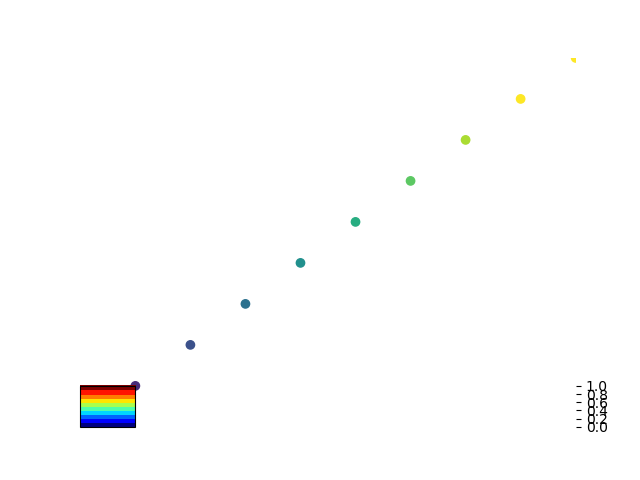

In [55]:
x = np.arange(0,10)
y = np.arange(0,10)
fig, ax = plt.subplots()
ax.scatter(x,y,c=x,norm=norm)
mpl.colorbar.ColorbarBase(ax, cmap = plt.cm.get_cmap('jet',10))
#add_colorbar(fig=fig,ax=ax,norm=norm)


In [ ]:
def discrete_cmap(cmap,n_colors):
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = cmap.from_list('Custom',cmaplist,cmap.N)
    bounds = np.arange(0,ncolors)
    

<IPython.core.display.Javascript object>


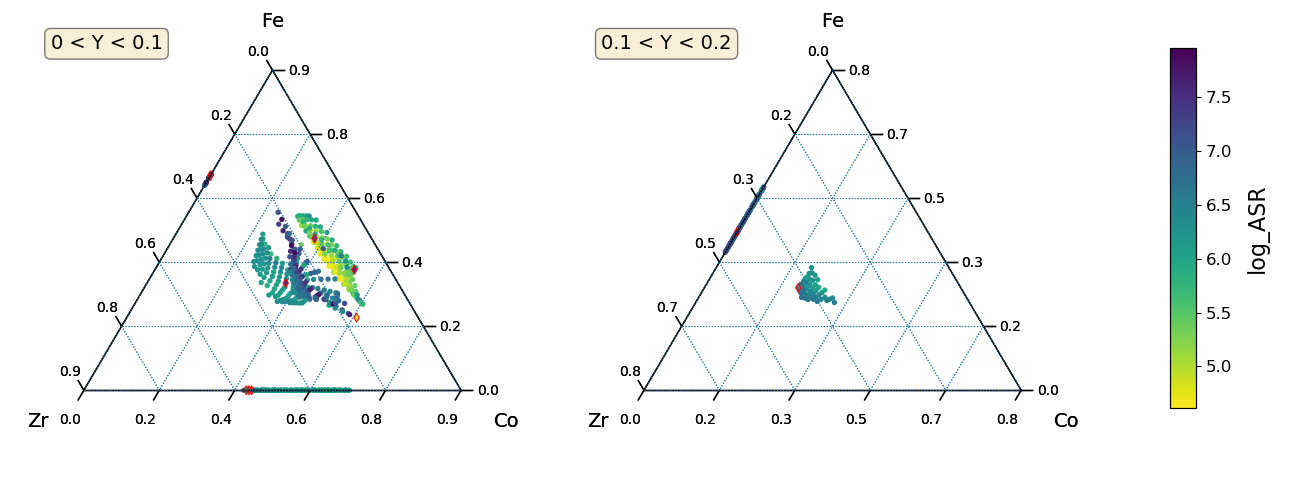

Scale: 0.95
Scale: 0.85
Scale: 0.95
Scale: 0.85


C:\Users\jdhuang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


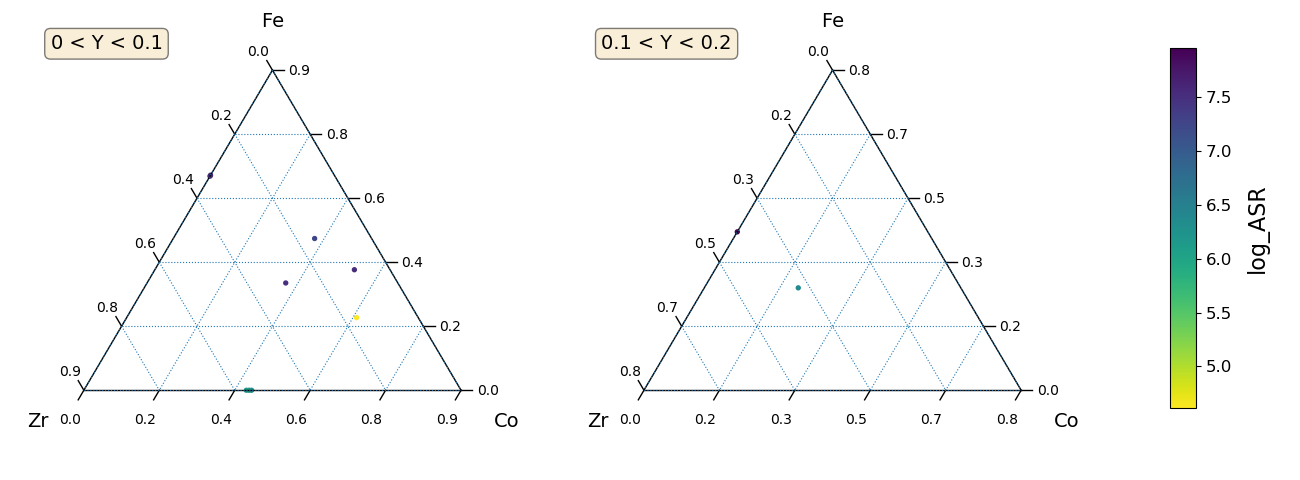

Scale: 0.95
Scale: 0.85


<IPython.core.display.Javascript object>


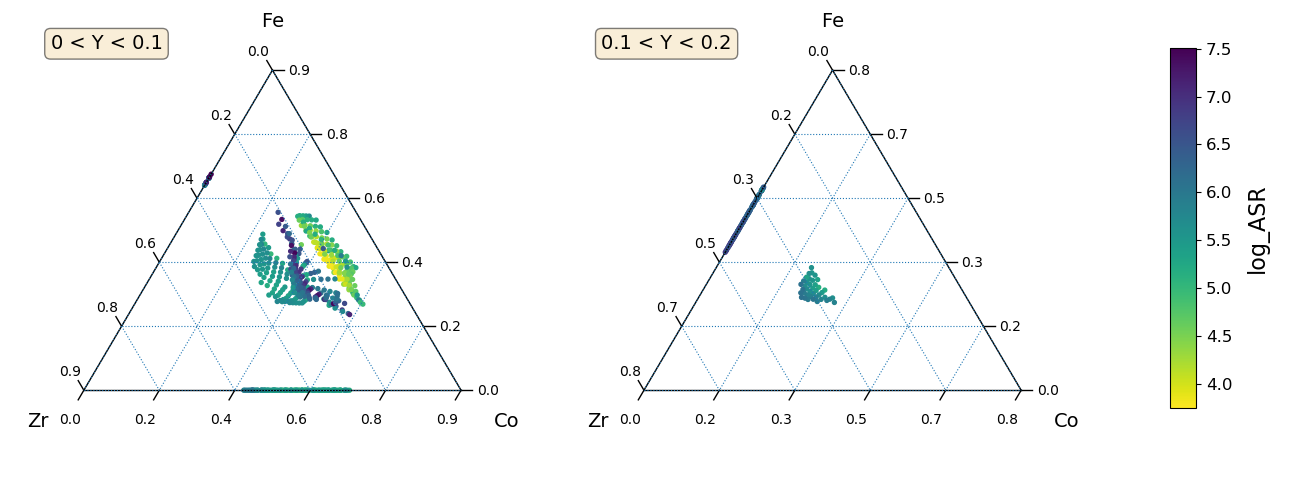

Scale: 0.95
Scale: 0.85


In [141]:
plot_kw = dict(slice_axis='Y',slice_starts=[0,0.1],slice_widths=0.1,tern_axes=['Co','Fe','Zr'],add_labeloffset=0.05,ncols=2,cmap=plt.cm.viridis_r)
#plot_kw = dict(slice_axis='Zr',slice_starts=[0.0,0.15,0.3,0.45],slice_widths=0.15,tern_axes=['Co','Fe','Y'],ncols=2,add_labeloffset=0.05)

dc.highlight_outliers(**plot_kw)
dc.plot_outliers(**plot_kw)
dc.plot_inliers(**plot_kw)
#dc.plot_clusters(**plot_kw,cmap=plt.cm.plasma)

IndexError: too many indices for array

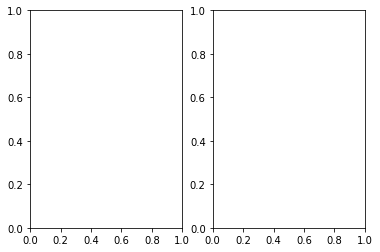

In [139]:
fig, axes = plt.subplots(1,2)
axes[0,1]

In [55]:
dc.scale_composition()
dc.data

ValueError: Must have equal len keys and value when setting with an ndarray

In [66]:
help(IsolationForest.predict)

Help on function predict in module sklearn.ensemble.iforest:

predict(self, X)
    Predict if a particular sample is an outlier or not.
    
    Parameters
    ----------
    X : array-like or sparse matrix, shape (n_samples, n_features)
        The input samples. Internally, it will be converted to
        ``dtype=np.float32`` and if a sparse matrix is provided
        to a sparse ``csr_matrix``.
    
    Returns
    -------
    is_inlier : array, shape (n_samples,)
        For each observations, tells whether or not (+1 or -1) it should
        be considered as an inlier according to the fitted model.



In [20]:
help(mg.periodic_table.Element)

Help on class Element in module pymatgen.core.periodic_table:

class Element(enum.Enum)
 |  Basic immutable element object with all relevant properties.
 |  Only one instance of Element for each symbol is stored after creation,
 |  ensuring that a particular element behaves like a singleton. For all
 |  attributes, missing data (i.e., data for which is not available) is
 |  represented by a None unless otherwise stated.
 |  
 |  Args:
 |      symbol (str): Element symbol, e.g., "H", "Fe"
 |  
 |  .. attribute:: Z
 |  
 |      Atomic number
 |  
 |  .. attribute:: symbol
 |  
 |      Element symbol
 |  
 |  .. attribute:: X
 |  
 |      Pauling electronegativity. Elements without an electronegativity
 |      number are assigned a value of zero by default.
 |  
 |  .. attribute:: number
 |  
 |      Alternative attribute for atomic number
 |  
 |  .. attribute:: max_oxidation_state
 |  
 |      Maximum oxidation state for element
 |  
 |  .. attribute:: min_oxidation_state
 |  
 |      M

In [21]:
mg.periodic_table.Element()

TypeError: __call__() missing 1 required positional argument: 'value'

In [62]:
help(mg.Element)

Help on class Element in module pymatgen.core.periodic_table:

class Element(enum.Enum)
 |  Basic immutable element object with all relevant properties.
 |  Only one instance of Element for each symbol is stored after creation,
 |  ensuring that a particular element behaves like a singleton. For all
 |  attributes, missing data (i.e., data for which is not available) is
 |  represented by a None unless otherwise stated.
 |  
 |  Args:
 |      symbol (str): Element symbol, e.g., "H", "Fe"
 |  
 |  .. attribute:: Z
 |  
 |      Atomic number
 |  
 |  .. attribute:: symbol
 |  
 |      Element symbol
 |  
 |  .. attribute:: X
 |  
 |      Pauling electronegativity. Elements without an electronegativity
 |      number are assigned a value of zero by default.
 |  
 |  .. attribute:: number
 |  
 |      Alternative attribute for atomic number
 |  
 |  .. attribute:: max_oxidation_state
 |  
 |      Maximum oxidation state for element
 |  
 |  .. attribute:: min_oxidation_state
 |  
 |      M